In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas as pd
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='bs4')


In [2]:
train = pd.read_csv('../input/sentiment-analysis-on-movie-reviews/train.tsv.zip', sep='\t')
test = pd.read_csv('../input/sentiment-analysis-on-movie-reviews/test.tsv.zip', sep='\t')

train.shape, test.shape

((156060, 4), (66292, 3))

In [3]:
train.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


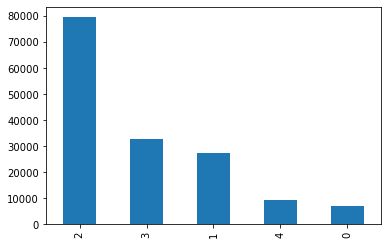

In [4]:
train['Sentiment'].value_counts().plot.bar()

In [ ]:
from bs4 import BeautifulSoup
import re
from tqdm import tqdm
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

# split by nltk.word_tokenizer
def data_preprocessing(df):
    reviews = []
    for raw in tqdm(df['Phrase']):
        # remove html tag
        text = BeautifulSoup(raw, 'lxml').get_text()
        # remove non-letters
        letters_only = re.sub('[^a-zA-Z]', ' ', text)
        # split(lowercase)
        words = word_tokenize(letters_only.lower())
        # get stoplist words
        stops = set(stopwords.words('english'))
        # remove stopwords / get non-stopwords list
        non_stopwords = [word for word in words if not word in stops]
        # lemmatize word to its lemma
        lemma_words = [lemmatizer.lemmatize(word) for word in non_stopwords]    
        reviews.append(lemma_words)
    return reviews


# data cleaning for train and test
%time train_sentences = data_preprocessing(train)
%time test_sentences = data_preprocessing(test)
len(train_sentences), len(test_sentences)

 52%|█████▏    | 80899/156060 [01:01<01:04, 1162.14it/s]

In [ ]:
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence

In [ ]:
target = train.Sentiment.values
y_target = to_categorical(target)
num_classes = y_target.shape[1]

num_classes

In [ ]:
# train_test_split train,validation 8:2
x_train, x_val, y_train, y_val = train_test_split(train_sentences, y_target, test_size=0.2, stratify=y_target)

In [ ]:
# unique words
unique_words = set()
len_max = 0

for senti in tqdm(x_train):
    unique_words.update(senti)
    if len_max < len(senti):
        len_max = len(senti)
        
len(unique_words), len_max

In [ ]:
tokenizer = Tokenizer(num_words=len(list(unique_words)))
tokenizer.fit_on_texts(list(x_train))

x_train = tokenizer.texts_to_sequences(x_train)
x_val = tokenizer.texts_to_sequences(x_val)
x_test = tokenizer.texts_to_sequences(test_sentences)

x_train = sequence.pad_sequences(x_train, maxlen=len_max)
x_val = sequence.pad_sequences(x_val, maxlen=len_max)
x_test = sequence.pad_sequences(x_test, maxlen=len_max)

In [ ]:
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.optimizers import Adam

In [ ]:
# (len(list(unique_Word)), 300, input = maxlen)

model = Sequential()
model.add(Embedding(len(list(unique_words)), 300, input_length=30))
model.add(LSTM(128, dropout=0.5, recurrent_dropout=0.5, return_sequences=True))
model.add(LSTM(64, dropout=0.5, recurrent_dropout=0.5))

model.add(Dense(100, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(5, activation='softmax'))

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [ ]:
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=10, batch_size=256)

In [ ]:
results = model.predict_classes(x_test)
submission = pd.read_csv('../input/sentiment-analysis-on-movie-reviews/sampleSubmission.csv')
submission.Sentiment = results
submission.to_csv('results.csv', index=False)